# Graph Neural Networks

Graph Neural Networks (GNNs) are a class of neural networks that operate on graphs. They are a powerful tool for solving problems in domains such as social network analysis, recommender systems, and combinatorial optimization.

You can read about Graph data structures /algorithms/graphs.html#graphs-data-structure section.

## Node Representations

The goal of a GNN is to learn a function that maps a graph to a representation of its nodes. This representation can then be used for various downstream tasks, such as node classification, link prediction, and clustering.

### DeepWalk

DeepWalk is a simple algorithm for learning node representations in a graph. It works by performing random walks on the graph, and using the SkipGram model from Word2Vec to learn the embeddings of the nodes.

It introduces important concepts such as embeddings that are at the core of GNNs. Unlike traditional neural networks, the goal of this architecture is to produce representations that are then fed to other models, which perform downstream tasks (for example, node classification).

DeepWalk architecture and its two major components: **Word2Vec** and **random walks**.

#### Word2Vec

The first step to comprehending the DeepWalk algorithm is to understand its major component: Word2Vec.
it proposed a new technique to translate words into vectors (also known as embeddings) using large datasets of text. These representations can then be used in downstream tasks, such as sentiment classification.

One of the most surprising results of Word2Vec is its ability to solve analogies. A popular example is how it can answer the question “man is to woman, what king is to ___?” It can be calculated as follows:

##### CBOW versus skip-gram
its only goal is to produce high-quality embeddings.

The continuous bag-of-words (CBOW) model:

This is trained to predict a word using its surrounding context (words coming before and after the target word). The order of context words does not matter since their embeddings are summed in the model. The authors claim to obtain better results using four words before and after the one that is predicted.

The continuous skip-gram model:

Here, we feed a single word to the model and try to predict the words around it. Increasing the range of context words leads to better embeddings but also increases the training time.

```{image} https://i.stack.imgur.com/ShJJX.png
:alt: CBOW and skip-gram models
:width: 80%
:align: center
```

##### Creating skip-grams

For now, we will focus on the skip-gram model since it is the architecture used by DeepWalk. Skip-grams are implemented as pairs of words with the following structure ( target word, context word). where target word is the input and context word is the word to predict. The number of skip grams for the same target word depends on a parameter called context size.


| Context Size | Text | Skip-grams |
| :---: | :---: | :---: |
| 1 | the train was late. | ('the', 'train') |
|  | the train was late | $\begin{array}{l}\text { ('train', 'the') } \\\text { ('train', 'was') }\end{array}$ |
|  | the train was late | $\begin{array}{l}\text { ('was', 'train') } \\\text { ('was', 'late') }\end{array}$ |
|  | the train was late | ('late', 'was') |
| 2 | the train was late | $\begin{array}{l}\text { ('the', 'train') } \\\text { ('the', 'was') }\end{array}$ |
|  | the train was late | $\begin{array}{l}\text { ('train', 'the') } \\\text { ('train', 'was') } \\\text { ('train', 'late') }\end{array}$ |
|  | the train was late | $\begin{array}{l}\text { ('was', 'the') } \\\text { ('was', 'train') } \\\text { ('was', 'late') }\end{array}$ |
|  | the train was late | $\begin{array}{l}\text { ('late', 'train') } \\\text { ('late', 'was') }\end{array}$ |


The same idea can be applied to a corpus of text instead of a single sentence.


In [2]:
import numpy as np
np.random.seed(0)

CONTEXT_SIZE = 2

text = """Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nunc eu sem 
scelerisque, dictum eros aliquam, accumsan quam. Pellentesque tempus, lorem ut 
semper fermentum, ante turpis accumsan ex, sit amet ultricies tortor erat quis 
nulla. Nunc consectetur ligula sit amet purus porttitor, vel tempus tortor 
scelerisque. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices 
posuere cubilia curae; Quisque suscipit ligula nec faucibus accumsan. Duis 
vulputate massa sit amet viverra hendrerit. Integer maximus quis sapien id 
convallis. Donec elementum placerat ex laoreet gravida. Praesent quis enim 
facilisis, bibendum est nec, pharetra ex. Etiam pharetra congue justo, eget 
imperdiet diam varius non. Mauris dolor lectus, interdum in laoreet quis, 
faucibus vitae velit. Donec lacinia dui eget maximus cursus. Class aptent taciti
sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Vivamus
tincidunt velit eget nisi ornare convallis. Pellentesque habitant morbi 
tristique senectus et netus et malesuada fames ac turpis egestas. Donec 
tristique ultrices tortor at accumsan.
""".split()

# Create skipgrams
skipgrams = []
for i in range(CONTEXT_SIZE, len(text) - CONTEXT_SIZE):
    array = [text[j] for j in np.arange(i - CONTEXT_SIZE, i + CONTEXT_SIZE + 1) if j != i]
    skipgrams.append((text[i], array))

print(skipgrams[0:2])

[('dolor', ['Lorem', 'ipsum', 'sit', 'amet,']), ('sit', ['ipsum', 'dolor', 'amet,', 'consectetur'])]


In [3]:
vocab = set(text)
VOCAB_SIZE = len(vocab)
print(f"Length of vocabulary = {VOCAB_SIZE}")

Length of vocabulary = 121


In [4]:
from gensim.models.word2vec import Word2Vec

# Create Word2Vec
model = Word2Vec([text],
                 sg=1,   # Skip-gram
                 vector_size=10,
                 min_count=0,
                 window=2,
                 workers=1,
                 seed=0)

print(f'Shape of W_embed: {model.wv.vectors.shape}')

# Train model
model.train([text], total_examples=model.corpus_count, epochs=10)

# Print a word embedding
print('\nWord embedding =')
print(model.wv[0])

Shape of W_embed: (121, 10)

Word embedding =
[ 0.07156403  0.03257632  0.00209916 -0.04374931 -0.03398107 -0.08656936
 -0.09047253 -0.09552431 -0.06482638  0.0660186 ]


While this approach works well with small vocabularies, the computational cost of applying a full softmax function to millions of words (the vocabulary size ) is too costly in most cases.

Word2Vec (and DeepWalk) implements one of these techniques, called H-Softmax. Instead of a flat softmax that directly calculates the probability of every word, this technique uses a binary tree structure where leaves are words. Even more interestingly, a Huffman tree can be used, where infrequent words are stored at deeper levels than common words. In most cases, this dramatically speeds up the word prediction by a factor of at least 50.

H-Softmax can be activated in gensim using hs=1.

#### DeepWalk and random walks

Proposed in 2014 by Perozzi et al., DeepWalk quickly became extremely popular among graph researchers. It is a simple algorithm that can be used to learn node representations in a graph. It works by performing random walks on the graph, and using the SkipGram model from Word2Vec to learn the embeddings of the nodes.

The goal of DeepWalk is to produce high-quality feature representations of nodes in an unsupervised way. This architecture is heavily inspired by Word2Vec in NLP. However, instead of words, our dataset is composed of nodes. This is why we use random walks to generate meaningful sequences of nodes that act like sentences. The following diagram illustrates the connection between sentences and graphs:

```{image} https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781804617526/files/image/B19153_03_004.jpg
:alt: DeepWalk and random walks
:width: 80%
:align: center
```

**Sentences can be represented as graphs**

Why are random walks important? Even if nodes are randomly selected, the fact that they often appear together in a sequence means that they are close to each other. Under the network homophily hypothesis, nodes that are close to each other are similar. This is particularly the case in social networks, where people are connected to friends and family.

This idea is at the core of the DeepWalk algorithm: when nodes are close to each other, we want to obtain high similarity scores. On the contrary, we want low scores when they are farther apart.

Let’s implement a random walk function using a networkx graph:

We generate a random graph thanks to the erdos_renyi_graph function with a fixed number of nodes (10) and a predefined probability of creating an edge between two nodes (0.3):


/Users/ikram.ali/miniconda3/envs/ml_notes/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


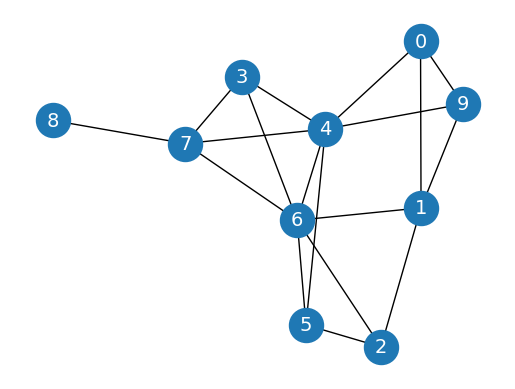

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)

# Plot graph
plt.figure()
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_size=600,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'
                 )

Let’s implement random walks with a simple function. This function takes two parameters: the starting node (start) and the length of the walk (length). At every step, we randomly select a neighboring node (using np.random.choice) until the walk is complete:

In [6]:
def random_walk(start, length):
    walk = [str(start)]  # starting node
    for i in range(length):
        neighbors = [node for node in G.neighbors(start)]
        next_node = np.random.choice(neighbors, 1)[0]
        walk.append(str(next_node))
        start = next_node
    return walk

In [7]:
print(random_walk(0, 10))

['0', '1', '9', '1', '0', '4', '6', '7', '6', '5', '6']


We can see that certain nodes, such as 0 and 9, are often found together. Considering that it is a homophilic graph, it means that they are similar. It is precisely the type of relationship we’re trying to capture with DeepWalk.

Now that we have implemented Word2Vec and random walks separately, let’s combine them to create DeepWalk.

##### Implementing DeepWalk

The dataset we will use is Zachary’s Karate Club. It simply represents the relationships within a karate club studied by Wayne W. Zachary in the 1970s. It is a kind of social network where every node is a member, and members who interact outside the club are connected.

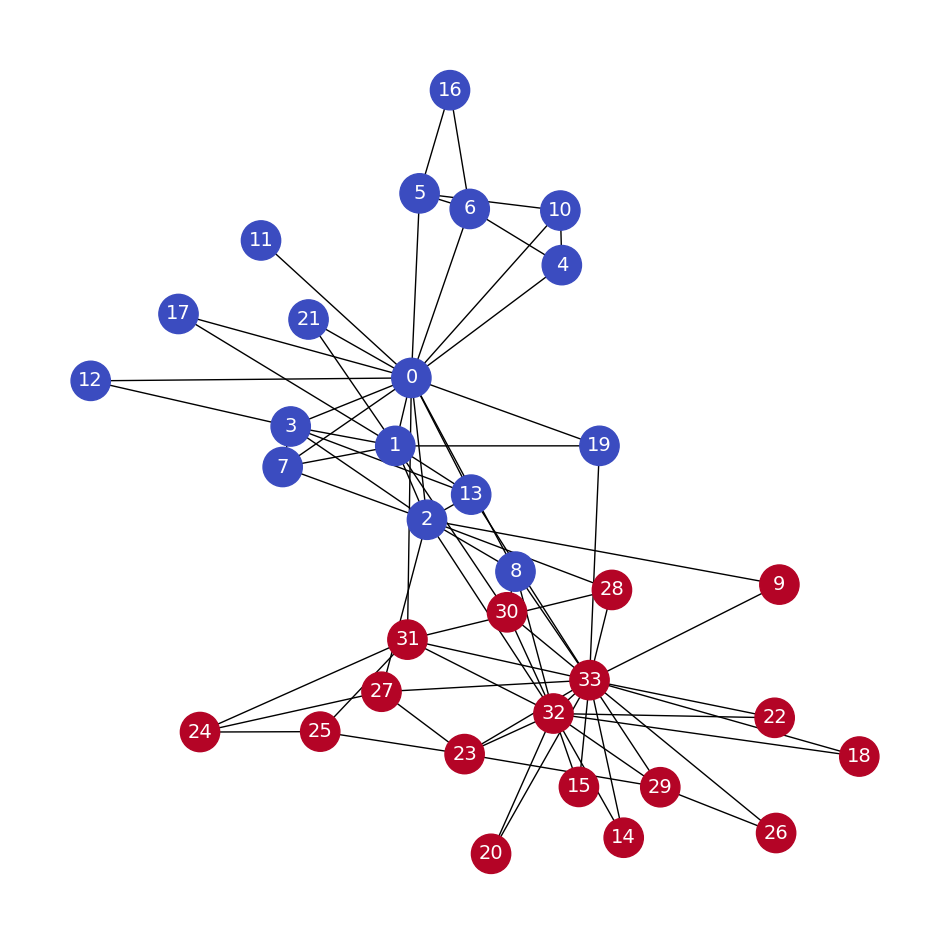

In [8]:
G = nx.karate_club_graph()

# Process labels (Mr. Hi = 0, Officer = 1)
labels = []
for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

# Plot graph
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_color=labels,
                 node_size=800,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'
                 )

The next step is to generate our dataset, the random walks. We want to be as exhaustive as possible, which is why we will create 80 random walks of a length of 10 for every node in the graph

In [9]:
walks = []
for node in G.nodes:
    for _ in range(80):
        walks.append(random_walk(node, 10))

In [10]:
walks[:10]

[['0', '10', '0', '17', '0', '2', '13', '0', '2', '9', '33'],
 ['0', '19', '0', '11', '0', '5', '16', '5', '16', '6', '5'],
 ['0', '31', '0', '3', '7', '0', '2', '7', '1', '7', '3'],
 ['0', '21', '1', '0', '2', '32', '30', '33', '8', '30', '1'],
 ['0', '8', '32', '33', '13', '0', '1', '13', '0', '5', '6'],
 ['0', '31', '32', '30', '32', '31', '0', '2', '1', '21', '1'],
 ['0', '11', '0', '4', '10', '5', '10', '0', '21', '1', '17'],
 ['0', '17', '1', '13', '3', '12', '0', '5', '16', '6', '0'],
 ['0', '4', '0', '5', '0', '10', '5', '16', '5', '16', '5'],
 ['0', '8', '0', '2', '9', '33', '14', '32', '20', '32', '2']]

The final step consists of implementing Word2Vec. Here, we use the skip-gram model previously seen with H-Softmax. You can play with the other parameters to improve the quality of the embeddings:

In [11]:
model = Word2Vec(walks,
                 hs=1,   # Hierarchical softmax
                 sg=1,   # Skip-gram
                 vector_size=100,
                 window=10,
                 workers=1,
                 seed=1)

print(f'Shape of embedding matrix: {model.wv.vectors.shape}')

# Build vocabulary
model.build_vocab(walks)

# Train model
model.train(walks, total_examples=model.corpus_count, epochs=30, report_delay=1)

Shape of embedding matrix: (34, 100)


(186095, 897600)

In [12]:
# Most similar nodes
print('Nodes that are the most similar to node 0:')
for similarity in model.wv.most_similar(positive=['0']):
    print(f'   {similarity}')

# Similarity between two nodes
print(f"\nSimilarity between node 0 and 4: {model.wv.similarity('0', '4')}")

Nodes that are the most similar to node 0:
   ('7', 0.6418750882148743)
   ('11', 0.6362574696540833)
   ('10', 0.6352985501289368)
   ('4', 0.6283851265907288)
   ('1', 0.624032199382782)
   ('17', 0.6081531047821045)
   ('6', 0.5763437151908875)
   ('5', 0.5598757266998291)
   ('21', 0.557222843170166)
   ('16', 0.5503911972045898)

Similarity between node 0 and 4: 0.628385066986084


In [13]:
# from sklearn.manifold import TSNE

In [14]:
# nodes_wv = np.array([model.wv.get_vector(str(i)) for i in range(len(model.wv))])
# labels = np.array(labels)

In [15]:
# tsne = TSNE(n_components=2,
#             learning_rate='auto',
#             init='pca',
#             random_state=0).fit_transform(nodes_wv)

In [16]:
# plt.figure(figsize=(6, 6), dpi=300)
# plt.scatter(tsne[:, 0], tsne[:, 1], s=100, c=labels, cmap="coolwarm")
# plt.show()

This plot is quite encouraging since we can see a clear line that separates the two classes. It should be possible for a simple ML algorithm to classify these nodes with enough examples (training data). Let’s implement a classifier and train it on our node embeddings

Our model obtains an accuracy score of 95.45%, which is pretty good considering the unfavorable train/test split we gave it. There is still room for improvement, but this example showed two useful applications of DeepWalk:

- Discovering similarities between nodes using embeddings and cosine similarity (unsupervised learning)
- Using these embeddings as a dataset for a supervised task such as node classification



In [17]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score

# # Create masks to train and test the model
# train_mask = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
# test_mask = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33]

# # Train classifier
# clf = RandomForestClassifier(random_state=0)
# clf.fit(nodes_wv[train_mask], labels[train_mask])

# # Evaluate accuracy
# y_pred = clf.predict(nodes_wv[test_mask])
# acc = accuracy_score(y_pred, labels[test_mask])
# print(f'Accuracy = {acc*100:.2f}%')

### Node2vec

Node2Vec is an architecture largely based on DeepWalk. DeepWalk the two main components of this architecture: random walks and Word2Vec. How can we improve the quality of our embeddings?

Node2Vec is an algorithmic framework for representational learning on graphs. Given any graph, it can learn continuous feature representations for the nodes, which can then be used for various downstream machine learning tasks. For example, we can use these embeddings as features for node classification, link prediction, clustering, and visualization.

Node2Vec was introduced in 2016 by Grover and Leskovec from Stanford University. It keeps the same two main components from DeepWalk: random walks and Word2Vec. The difference is that instead of obtaining sequences of nodes with a uniform distribution, the random walks are carefully biased in Node2Vec. We will see why these biased random walks perform better and how to implement them in the two following sections:

- Defining a neighborhood
- Introducing biases in random walks

#### Defining a neighborhood

How do you define the neighborhood of a node? what does “close” mean in the context of a graph?

```{image} https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781804617526/files/image/B19153_04_001.jpg
:alt: Defining a neighborhood
:width: 80%
:align: center
```
We want to explore three nodes in the neighborhood of node A. This exploration process is also called a sampling strategy:

- A possible solution would be to consider the three closest nodes in terms of connections. In this case, the neighborhood of $A$, noted $N(A)$, would
$$
N(A)=\{B, C, D\}
$$
- Another possible sampling strategy consists of selecting nodes that are not adjacent to previous nodes first. In our example, the neighborhood of $A$ would be $N(A)=\{D, \boldsymbol{F}, \boldsymbol{F}\}$

In other words, we want to implement a Breadth-First Search (BFS) in the first case and a Depth-First Search (DFS) in the second one. You can find more information about these algorithms and implementations in Chapter 2, Graph Theory for Graph Neural Networks.

The best way to understand this is to actually implement this architecture and play with the parameters.


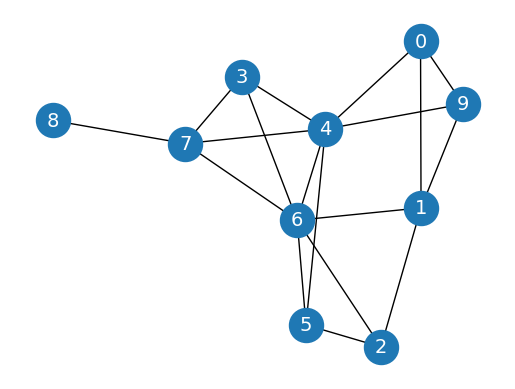

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
import random
random.seed(0)
import numpy as np
np.random.seed(0)

# Create graph
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)

# Plot graph
plt.figure()
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_size=600,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'
                 )

In [19]:

def next_node(previous, current, p, q):
    alphas = []

    # Get the neighboring nodes
    neighbors = list(G.neighbors(current))
    
    # Calculate the appropriate alpha value for each neighbor
    for neighbor in neighbors:
        # Distance = 0: probability to return to the previous node
        if neighbor == previous:
            alpha = 1/p
        # Distance = 1: probability of visiting a local node
        elif G.has_edge(neighbor, previous):
            alpha = 1
        # Distance = 2: probability to explore an unknown node
        else:
            alpha = 1/q
        alphas.append(alpha)

    # Normalize the alpha values to create transition probabilities
    probs = [alpha / sum(alphas) for alpha in alphas]
    
    # Randomly select the new node based on the transition probabilities
    next = np.random.choice(neighbors, size=1, p=probs)[0]
    return next

In [20]:
def random_walk(start, length, p, q):
    walk = [start]
    
    for i in range(length):
        current = walk[-1]
        previous = walk[-2] if len(walk) > 1 else None
        next = next_node(previous, current, p, q)
        walk.append(next)
    
    return walk

In [21]:
random_walk(0, 8, p=1, q=1)

[0, 4, 7, 6, 4, 5, 4, 5, 6]

In [22]:
random_walk(0, 8, p=1, q=10)


[0, 9, 1, 9, 1, 9, 1, 0, 1]

#### Implementing Node2Vec

Now that we have the functions to generate biased random walks, the implementation of Node2Vec is very similar to implementing DeepWalk.



In [23]:
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load dataset
G = nx.karate_club_graph()

# Process labels (Mr. Hi = 0, Officer = 1)
labels = []
for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

# Create a list of random walks
walks = []
for node in G.nodes:
    for _ in range(80):
        walks.append(random_walk(node, 10, 3, 2))

# Create and train Word2Vec for DeepWalk
node2vec = Word2Vec(walks,
                hs=1,   # Hierarchical softmax
                sg=1,   # Skip-gram
                vector_size=100,
                window=10,
                workers=2,
                min_count=1,
                seed=0)
node2vec.train(walks, total_examples=node2vec.corpus_count, epochs=30, report_delay=1)

# Create masks to train and test the model
train_mask = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
test_mask = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33]
labels = np.array(labels)

# Train Node2Vec classifier
clf = RandomForestClassifier(random_state=0)
clf.fit(node2vec.wv[train_mask], labels[train_mask])

# Evaluate accuracy
y_pred = clf.predict(node2vec.wv[test_mask])
acc = accuracy_score(y_pred, labels[test_mask])
print(f'Node2Vec accuracy = {acc*100:.2f}%')

Node2Vec accuracy = 100.00%


#### Building a movie RecSys with Node2Vec

One of the most popular applications of GNNs is RecSys. If you think about the foundation of Word2Vec (and, thus, DeepWalk and Node2Vec), the goal is to produce vectors with the ability to measure their similarity. Encode movies instead of words, and you can suddenly ask for movies that are the most similar to a given input title. It sounds a lot like a RecSys, right?

Another approach is to look at user ratings. There are different techniques to build a graph based on ratings: bipartite graphs, edges based on pointwise mutual information, and so on. In this section, we’ll implement a simple and intuitive approach: movies that are liked by the same users are connected. We’ll then use this graph to learn movie embeddings using Node2Vec:

In [24]:
# from io import BytesIO
# from urllib.request import urlopen
# from zipfile import ZipFile

# url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
# with urlopen(url) as zurl:
#     with ZipFile(BytesIO(zurl.read())) as zfile:
#         zfile.extractall('.')

In [25]:
# import pandas as pd

# ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'unix_timestamp'])
# ratings

In [26]:
# movies = pd.read_csv('ml-100k/u.item', sep='|', usecols=range(2), names=['movie_id', 'title'], encoding='latin-1')


In [27]:
# Here, we want to see movies that have been liked by the same users. 
# This means that ratings such as 1, 2, and 3 are not very relevant.
#  We can discard those and only keep scores of 4 and 5

# ratings = ratings[ratings.rating >= 4]
# ratings

We now have 48,580 ratings made by 610 users. The next step is to count every time that two movies are liked by the same user. We will repeat this process for every user in the dataset.

To simplify things, we will use a defaultdict data structure, which automatically creates missing entries instead of raising an error. We’ll use this structure to count movies that are liked together:

In [28]:
# from collections import defaultdict
# pairs = defaultdict(int)

In [29]:
# # Loop through the entire list of users
# for group in ratings.groupby("user_id"):
#     # List of IDs of movies rated by the current user
#     user_movies = list(group[1]["movie_id"])

#     # Count every time two movies are seen together
#     for i in range(len(user_movies)):
#         for j in range(i+1, len(user_movies)):
#             pairs[(user_movies[i], user_movies[j])] += 1

In [30]:
# For each pair of movies in our pairs structure, we unpack the two movies and their corresponding score:

# Create a networkx graph
# G = nx.Graph()

# # Try to create an edge between movies that are liked together
# for pair in pairs:
#     if not isinstance(pair, tuple):
#         continue
#     movie1, movie2 = pair
#     score = pairs[pair]

#     # The edge is only created when the score is high enough
#     if score >= 20:
#         G.add_edge(movie1, movie2, weight=score)

# print("Total number of graph nodes:", G.number_of_nodes())
# print("Total number of graph edges:", G.number_of_edges())



In [31]:
# !pip install node2vec

In [32]:
# from node2vec import Node2Vec

# node2vec = Node2Vec(G, dimensions=64, walk_length=20, num_walks=200, p=2, q=1, workers=1)

# model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [33]:
# def recommend(movie):
#     movie_id = str(movies[movies.title == movie].movie_id.values[0])
#     for id in model.wv.most_similar(movie_id)[:5]:
#         title = movies[movies.movie_id == int(id[0])].title.values[0]
#         print(f'{title}: {id[1]:.2f}')

# recommend('Star Wars (1977)')

### Vanilla Neural Networks

However, graph datasets tend to be richer than a mere set of connections: nodes and edges can also have features to represent scores, colors, words, and so on. Including this additional information in our input data is essential to produce the best embeddings possible.

#### The Cora dataset

Introduced by Sen et al. in 2008 [1], Cora (no license) is the most popular dataset for node classification in the scientific literature. It represents a network of 2,708 publications, where each connection is a reference. Each publication is described as a binary vector of 1,433 unique words, where 0 and 1 indicate the absence or presence of the corresponding word, respectively. This representation is also called a binary bag of words in natural language processing. Our goal is to classify each node into one of seven categories.





In [34]:
# !pip install torch_geometric

In [35]:
# from torch_geometric.datasets import Planetoid

In [36]:
# dataset = Planetoid(root=".", name="Cora")

In [37]:
# data = dataset[0]


In [38]:
# print(f'Dataset: {dataset}')
# print('---------------')
# print(f'Number of graphs: {len(dataset)}')
# print(f'Number of nodes: {data.x.shape[0]}')
# print(f'Number of features: {dataset.num_features}')
# print(f'Number of classes: {dataset.num_classes}')

In [39]:
# print(f'Graph:')
# print('------')
# print(f'Edges are directed: {data.is_directed()}')
# print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
# print(f'Graph has loops: {data.has_self_loops()}')

In [40]:
# from torch_geometric.datasets import FacebookPagePage

In [41]:
# dataset = FacebookPagePage(root=".")

In [42]:
# data = dataset[0]

In [43]:
# print(f'Dataset: {dataset}')
# print('-----------------------')
# print(f'Number of graphs: {len(dataset)}')
# print(f'Number of nodes: {data.x.shape[0]}')
# print(f'Number of features: {dataset.num_features}')
# print(f'Number of classes: {dataset.num_classes}')

In [44]:
# print(f'\nGraph:')
# print('------')
# print(f'Edges are directed: {data.is_directed()}')
# print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
# print(f'Graph has loops: {data.has_self_loops()}')

In [45]:
# data.train_mask = range(18000)
# data.val_mask = range(18001, 20000)
# data.test_mask = range(20001, 22470)

In [46]:
# import pandas as pd

# dataset = Planetoid(root=".", name="Cora")
# data = dataset[0]

# df_x = pd.DataFrame(data.x.numpy())
# df_x['label'] = pd.DataFrame(data.y)
# df_x

Classifying nodes with vanilla neural networks

Compared to Zachary’s Karate Club, these two datasets include a new type of information: node features. They provide additional information about the nodes in a graph, such as a user’s age, gender, or interests in a social network. In a vanilla neural network (also called multilayer perceptron), these embeddings are directly used in the model to perform downstream tasks such as node classification.


we will consider node features as a regular tabular dataset. We will train a simple neural network on this dataset to classify our nodes. Note that this architecture does not take into account the topology of the network. We will try to fix this issue in the next section and compare our results.

The tabular dataset of node features can be easily accessed through the data object we created.

If you’re familiar with machine learning, you probably recognize a typical dataset with data and labels. We can develop a simple Multilayer Perceptron (MLP) and train it on data.x with the labels provided by data.y.


In [47]:
# import torch
# torch.manual_seed(0)
# from torch.nn import Linear
# import torch.nn.functional as F


# def accuracy(y_pred, y_true):
#     """Calculate accuracy."""
#     return torch.sum(y_pred == y_true) / len(y_true)


# class MLP(torch.nn.Module):
#     """Multilayer Perceptron"""
#     def __init__(self, dim_in, dim_h, dim_out):
#         super().__init__()
#         self.linear1 = Linear(dim_in, dim_h)
#         self.linear2 = Linear(dim_h, dim_out)

#     def forward(self, x):
#         x = self.linear1(x)
#         x = torch.relu(x)
#         x = self.linear2(x)
#         return F.log_softmax(x, dim=1)

#     def fit(self, data, epochs):
#         criterion = torch.nn.CrossEntropyLoss()
#         optimizer = torch.optim.Adam(self.parameters(),
#                                           lr=0.01,
#                                           weight_decay=5e-4)

#         self.train()
#         for epoch in range(epochs+1):
#             optimizer.zero_grad()
#             out = self(data.x)
#             loss = criterion(out[data.train_mask], data.y[data.train_mask])
#             acc = accuracy(out[data.train_mask].argmax(dim=1),
#                           data.y[data.train_mask])
#             loss.backward()
#             optimizer.step()

#             if(epoch % 20 == 0):
#                 val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
#                 val_acc = accuracy(out[data.val_mask].argmax(dim=1),
#                                   data.y[data.val_mask])
#                 print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
#                       f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
#                       f'Val Acc: {val_acc*100:.2f}%')

#     @torch.no_grad()      
#     def test(self, data):
#         self.eval()
#         out = self(data.x)
#         acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
#         return acc

# # Create MLP model
# mlp = MLP(dataset.num_features, 16, dataset.num_classes)
# print(mlp)

# # Train
# mlp.fit(data, epochs=100)

# # Test
# acc = mlp.test(data)
# print(f'\nMLP test accuracy: {acc*100:.2f}%')

### Vanilla graph neural networks

Instead of directly introducing well-known GNN architectures, let’s try to build our own model to understand the thought process behind GNNs.

A basic neural network layer corresponds to a linear transformation
$h_A=x_A W^T x_{A_{\text {is the input vector of node }}} A_{\text {and }}$
$\mathbf{V}$ is the weight matrix. In PyTorch, this equation can be implemented with the torch .mm () function, or with the $\mathrm{nn}$. Linear class that adds other parameters such as biases.

With our graph datasets, the input vectors are node features. It means that nodes are completely separate from each other. This is not enough to capture a good understanding of the graph: like a pixel in an image, the context of a node is essential to understand it. If you look at a group of pixels instead of a single one, you can recognize edges, patterns, and so on. Likewise, to understand a node, you need to look at its neighborhood.

${ }_{\text {Lers call }} N_A$ the set of neighbors of node A. Our graph linear layer can be written as follows:
$$
h_A=\sum_{i \in \mathcal{N}_A} x_i W^T
$$
You can imagine several variants of this equation. For instance, we could have a
weight matrix
the neighbors. Note that we cannot have a weight matrix per neighbor, as this
number can change from node to node.

We're talking about neural networks, so we can't apply the previous equation to each node. Instead, we perform matrix multiplications that are much more efficient. For instance, the equation of the linear layer can be rewritten as
$$
\boldsymbol{H}=\boldsymbol{Y} \boldsymbol{T} \text {, where } \boldsymbol{X} \text { is the input matrix. }
$$
In our case, the adjacency matrix $\boldsymbol{A}$ contains the connections between every node in the graph. Multiplying the input matrix by this adjacency matrix will directly sum up the neighboring node features. We can add self loops to the adjacency matrix so that the central node is also considered in this operation. We call this updated adjacency matrix $\tilde{A}=A+\boldsymbol{A}$. Our graph linear layer can be rewritten as follows:
$$
H=\tilde{A}^T X W^T
$$
Let's test this layer by implementing it in PyTorch Geometric. We'll then be able to use it as a regular layer to build a GNN:


In [48]:
# class VanillaGNNLayer(torch.nn.Module):
#     def __init__(self, dim_in, dim_out):
#         super().__init__()
#         self.linear = Linear(dim_in, dim_out, bias=False)

#     def forward(self, x, adjacency):
#         x = self.linear(x)
#         # We perform two operations – the linear transformation,
#         #  and then the multiplication with the adjacency matrix
#         x = torch.sparse.mm(adjacency, x)
#         return x

Before we can create our vanilla GNN, we need to convert the edge index from our dataset (data.edge_index) in coordinate format to a dense adjacency matrix. We also need to include self loops; otherwise, the central nodes won’t be taken into account in their own embeddings.



In [49]:
# from torch_geometric.utils import to_dense_adj
# adjacency = to_dense_adj(data.edge_index)[0]
# adjacency += torch.eye(len(adjacency))
# adjacency

In [50]:
# class VanillaGNN(torch.nn.Module):
#     def __init__(self, dim_in, dim_h, dim_out):
#         super().__init__()
#         self.gnn1 = VanillaGNNLayer(dim_in, dim_h)
#         self.gnn2 = VanillaGNNLayer(dim_h, dim_out)
    
#     # We perform the same operations with our new layers,
#     #  which take the adjacency matrix we previously calculated as an additional input:
#     def forward(self, x, adjacency):
#         h = self.gnn1(x, adjacency)
#         h = torch.relu(h)
#         h = self.gnn2(h, adjacency)
#         return F.log_softmax(h, dim=1)
    
#     def fit(self, data, epochs):
#         criterion = torch.nn.CrossEntropyLoss()
#         optimizer = torch.optim.Adam(self.parameters(),
#                                       lr=0.01,
#                                       weight_decay=5e-4)

#         self.train()
#         for epoch in range(epochs+1):
#             optimizer.zero_grad()
#             out = self(data.x, adjacency)
#             loss = criterion(out[data.train_mask], data.y[data.train_mask])
#             acc = accuracy(out[data.train_mask].argmax(dim=1),
#                           data.y[data.train_mask])
#             loss.backward()
#             optimizer.step()

#             if(epoch % 20 == 0):
#                 val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
#                 val_acc = accuracy(out[data.val_mask].argmax(dim=1),
#                                   data.y[data.val_mask])
#                 print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
#                       f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
#                       f'Val Acc: {val_acc*100:.2f}%')
    
#     torch.no_grad()
#     def test(self, data):
#         self.eval()
#         out = self(data.x, adjacency)
#         acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
#         return acc


# # Create the Vanilla GNN model
# gnn = VanillaGNN(dataset.num_features, 16, dataset.num_classes)
# print(gnn)
# # Train
# gnn.fit(data, epochs=100)
# # Test
# acc = gnn.test(data)
# print(f'\nGNN test accuracy: {acc*100:.2f}%')



## Graph Convolutional Networks

The Graph Convolutional Network (GCN) architecture is the blueprint of what a GNN looks like.

In this chapter, we’ll talk about the limitations of our previous vanilla GNN layer. This will help us to understand the motivation behind GCNs. We’ll detail how the GCN layer works and why it performs better than our solution.

The last section is dedicated to a new task: node regression. This is not a very common task when it comes to GNNs, but it is particularly useful when you’re working with tabular data.

### Designing the graph convolutional layer
Unlike tabular or image data, nodes do not always have the same number of neighbors. However, if we look at our GNN layer, we don’t take into account this difference in the number of neighbors. Our layer consists of a simple sum without any normalization coefficient.



Here is how we calculated the embedding of a node i, 

$$
h_i=\sum_{j \in \mathcal{N}_i} x_j W^T
$$





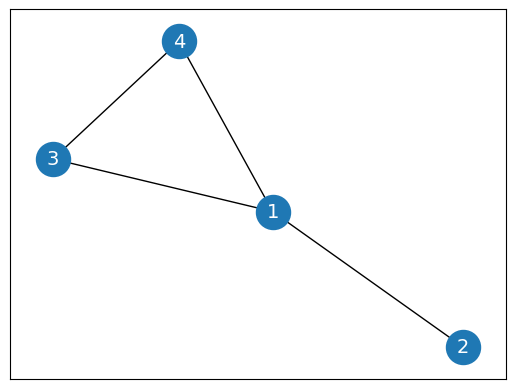

In [53]:
G = nx.Graph()
G.add_edges_from([(1, 2), (1, 3), (1, 4), (3,4)])

nx.draw_networkx(G, pos=nx.spring_layout(G, seed=0), node_size=600, cmap='coolwarm', font_size=14, font_color='white')

Imagine that node 1 has 1,000 neighbors and node 2 only has 1: the embedding  will have much larger values than . This is an issue because we want to compare these embeddings. How are we supposed to make meaningful comparisons when their values are so vastly different?

Fortunately, there is a simple solution: dividing the embedding by the number of neighbors.

Let’s write the degree of node deg(A) . Here is the new formula for the GNN layer

$$
h_i=\frac{1}{\operatorname{deg}(i)} \sum_{j \in \mathcal{N}_i} x_j W^T
$$

But how do we translate it into a matrix multiplication? As a reminder, this was what we obtained for our vanilla GNN layer:

$$
\begin{gathered}
H=\tilde{A}^T X W^T \\
\text { Here, } \tilde{A}=A+I
\end{gathered}
$$

The only thing that is missing from this formula is a matrix to give us the normalization coefficient, $\overline{\operatorname{deg}(i)}$. This is something that can be obtained thanks to the degree matrix $\boldsymbol{D}$, which counts the number of neighbors for each node. Here


Here is the same matrix in numpy

In [55]:
import numpy as np
D = np.array([
    [3, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 2, 0],
    [0, 0, 0, 2]
])

np.linalg.inv(D)

array([[0.33333333, 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.5       , 0.        ],
       [0.        , 0.        , 0.        , 0.5       ]])

This is exactly what we were looking for. To be even more accurate, we added
self-loops to the graph, A = A + 1

NumPy has a specific function, numpy.identity(n), to quickly create an identity matrix l  of n  dimensions


In [56]:
np.linalg.inv(D + np.identity(4))

array([[0.25      , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.        , 0.33333333]])

### Comparing graph convolutional and graph linear layers

In the previous chapter, our vanilla GNN outperformed the Node2Vec model, but how does it compare to a GCN? In this section, we will compare their performance on the Cora and Facebook Page-Page datasets.

Compared to the vanilla GNN, the main feature of the GCN is that it considers node degrees to weigh its features. Before the real implementation, let’s analyze the node degrees in both datasets. This information is relevant since it is directly linked to the performance of the GCN.

In [57]:
# from torch_geometric.datasets import Planetoid
# from torch_geometric.utils import degree
# from collections import Counter
# import matplotlib.pyplot as plt

<BarContainer object of 37 artists>

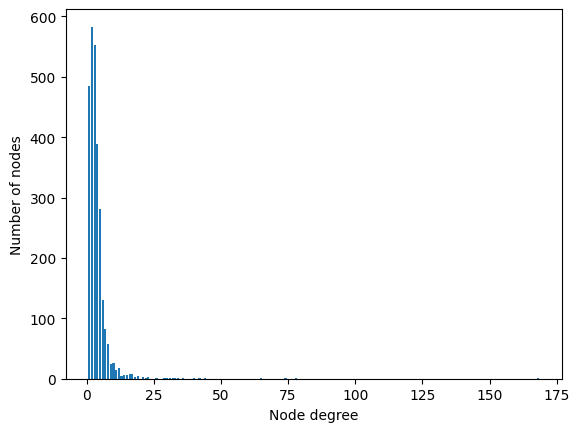

In [61]:
# dataset = Planetoid(root=".", name="Cora")
# data = dataset[0]

# # Get list of degrees for each node
# degrees = degree(data.edge_index[0]).numpy()

# # Count the number of nodes for each degree
# numbers = Counter(degrees)

# # Bar plot
# fig, ax = plt.subplots()
# ax.set_xlabel('Node degree')
# ax.set_ylabel('Number of nodes')
# plt.bar(numbers.keys(), numbers.values())

Processing...
Done!


<BarContainer object of 233 artists>

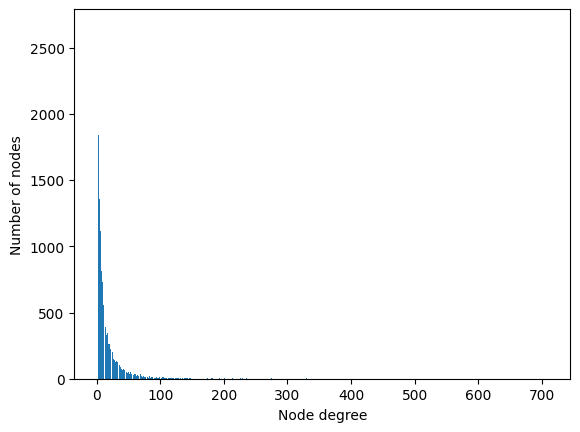

In [62]:
# from torch_geometric.datasets import FacebookPagePage

# # Import dataset from PyTorch Geometric
# dataset = FacebookPagePage(root=".")
# data = dataset[0]

# # Create masks
# data.train_mask = range(18000)
# data.val_mask = range(18001, 20000)
# data.test_mask = range(20001, 22470)

# # Get list of degrees for each node
# degrees = degree(data.edge_index[0]).numpy()

# # Count the number of nodes for each degree
# numbers = Counter(degrees)

# # Bar plot
# fig, ax = plt.subplots()
# ax.set_xlabel('Node degree')
# ax.set_ylabel('Number of nodes')
# plt.bar(numbers.keys(), numbers.values())

This distribution of node degrees looks even more skewed, with a number of neighbors that ranges from 1 to 709. For the same reason, the Facebook Page-Page dataset is also a good case in which to apply a GCN.

We could build our own graph layer but, conveniently enough, PyTorch Geometric already has a predefined GCN layer. Let’s implement it on the Cora dataset first:

In [63]:
# import torch
# torch.manual_seed(1)
# import torch.nn.functional as F
# from torch_geometric.nn import GCNConv

# dataset = Planetoid(root=".", name="Cora")
# data = dataset[0]

# def accuracy(y_pred, y_true):
#     """Calculate accuracy."""
#     return torch.sum(y_pred == y_true) / len(y_true)


# class GCN(torch.nn.Module):
#     """Graph Convolutional Network"""
#     def __init__(self, dim_in, dim_h, dim_out):
#         super().__init__()
#         self.gcn1 = GCNConv(dim_in, dim_h)
#         self.gcn2 = GCNConv(dim_h, dim_out)

#     def forward(self, x, edge_index):
#         h = self.gcn1(x, edge_index)
#         h = torch.relu(h)
#         h = self.gcn2(h, edge_index)
#         return F.log_softmax(h, dim=1)

#     def fit(self, data, epochs):
#         criterion = torch.nn.CrossEntropyLoss()
#         optimizer = torch.optim.Adam(self.parameters(),
#                                       lr=0.01,
#                                       weight_decay=5e-4)

#         self.train()
#         for epoch in range(epochs+1):
#             optimizer.zero_grad()
#             out = self(data.x, data.edge_index)
#             loss = criterion(out[data.train_mask], data.y[data.train_mask])
#             acc = accuracy(out[data.train_mask].argmax(dim=1),
#                           data.y[data.train_mask])
#             loss.backward()
#             optimizer.step()

#             if(epoch % 20 == 0):
#                 val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
#                 val_acc = accuracy(out[data.val_mask].argmax(dim=1),
#                                   data.y[data.val_mask])
#                 print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
#                       f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
#                       f'Val Acc: {val_acc*100:.2f}%')

#     @torch.no_grad()
#     def test(self, data):
#         self.eval()
#         out = self(data.x, data.edge_index)
#         acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
#         return acc

# # Create the Vanilla GNN model
# gcn = GCN(dataset.num_features, 16, dataset.num_classes)
# print(gcn)

# # Train
# gcn.fit(data, epochs=100)

# # Test
# acc = gcn.test(data)
# print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Epoch   0 | Train Loss: 1.932 | Train Acc: 15.71% | Val Loss: 1.94 | Val Acc: 15.20%
Epoch  20 | Train Loss: 0.099 | Train Acc: 100.00% | Val Loss: 0.75 | Val Acc: 77.80%
Epoch  40 | Train Loss: 0.014 | Train Acc: 100.00% | Val Loss: 0.72 | Val Acc: 77.20%
Epoch  60 | Train Loss: 0.015 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 77.80%
Epoch  80 | Train Loss: 0.017 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 77.00%
Epoch 100 | Train Loss: 0.016 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 76.40%

GCN test accuracy: 79.70%



If we repeat this experiment 100 times, we obtain an average accuracy score of 80.17% (± 0.61%), which is significantly higher than the 74.98% (± 1.50%) obtained by our vanilla GNN.

The exact same model is then applied to the Facebook Page-Page dataset, where it obtains an average accuracy of 91.54% (± 0.28%). Once again, it is significantly higher than the result obtained by the vanilla GNN, with only 84.85% (± 1.68%).We can attribute these high scores to the wide range of node degrees in these two datasets. By normalizing features and considering the number of neighbors of the central node and its own neighbors, the GCN gains a lot of flexibility and can work well with various types of graphs.

## Graph Attention Networks

Graph Attention Networks (GATs) are a theoretical improvement over GCNs. Instead of static normalization coefficients, they propose weighting factors calculated by a process called self-attention. The same process is at the core of one of the most successful deep learning architectures.

we will learn how the graph attention layer works in four steps. This is actually the perfect example for understanding how self-attention works in general. This theoretical background will allow us to implement a graph attention layer from scratch in NumPy.

### Introducing the graph attention layer

The main idea behind GATs is that some nodes are more important than others. In fact, this was already the case with the graph convolutional layer: nodes with few neighbors were more important than others, thanks to the normalization coefficient. This approach is limiting because it only takes into account node degrees. On the other hand, the goal of the graph attention layer is to produce weighting factors that also consider the importance of node features.

Let’s call our weighting factors attention scores and note, , the attention score between the nodes  and . We can define the graph attention operator as follows:

$$
h_i=\sum_{j \in \mathcal{N}_i} \alpha_{i j} \mathbf{W} x_j
$$

An important characteristic of GATs is that the attention scores are calculated implicitly by comparing inputs to each other (hence the name self-attention).

we will see how to calculate these attention scores in four steps and also how to make an improvement to the graph attention layer:

- Linear transformation
- Activation function
- Softmax normalization
- Multi-head attention
- Improved graph attention layer



In [64]:

# # Import dataset from PyTorch Geometric
# dataset = Planetoid(root=".", name="Cora")
# data = dataset[0]



In [65]:
# import torch
# torch.manual_seed(1)
# import torch.nn.functional as F
# from torch_geometric.nn import GATv2Conv, GCNConv
# from torch.nn import Linear, Dropout


# def accuracy(y_pred, y_true):
#     """Calculate accuracy."""
#     return torch.sum(y_pred == y_true) / len(y_true)


# class GAT(torch.nn.Module):
#     def __init__(self, dim_in, dim_h, dim_out, heads=8):
#         super().__init__()
#         self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
#         self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)

#     def forward(self, x, edge_index):
#         h = F.dropout(x, p=0.6, training=self.training)
#         h = self.gat1(h, edge_index)
#         h = F.elu(h)
#         h = F.dropout(h, p=0.6, training=self.training)
#         h = self.gat2(h, edge_index)
#         return F.log_softmax(h, dim=1)

#     def fit(self, data, epochs):
#         criterion = torch.nn.CrossEntropyLoss()
#         optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=0.01)

#         self.train()
#         for epoch in range(epochs+1):
#             optimizer.zero_grad()
#             out = self(data.x, data.edge_index)
#             loss = criterion(out[data.train_mask], data.y[data.train_mask])
#             acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
#             loss.backward()
#             optimizer.step()

#             if(epoch % 20 == 0):
#                 val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
#                 val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
#                 print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

#     @torch.no_grad()
#     def test(self, data):
#         self.eval()
#         out = self(data.x, data.edge_index)
#         acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
#         return acc

# # Create the Vanilla GNN model
# gat = GAT(dataset.num_features, 32, dataset.num_classes)
# print(gat)

# # Train
# gat.fit(data, epochs=100)

# # Test
# acc = gat.test(data)
# print(f'GAT test accuracy: {acc*100:.2f}%')

GAT(
  (gat1): GATv2Conv(1433, 32, heads=8)
  (gat2): GATv2Conv(256, 7, heads=1)
)
Epoch   0 | Train Loss: 1.978 | Train Acc: 12.86% | Val Loss: 1.94 | Val Acc: 13.80%
Epoch  20 | Train Loss: 0.238 | Train Acc: 96.43% | Val Loss: 1.04 | Val Acc: 67.20%
Epoch  40 | Train Loss: 0.165 | Train Acc: 98.57% | Val Loss: 0.95 | Val Acc: 71.00%
Epoch  60 | Train Loss: 0.209 | Train Acc: 96.43% | Val Loss: 0.91 | Val Acc: 71.80%
Epoch  80 | Train Loss: 0.173 | Train Acc: 100.00% | Val Loss: 0.93 | Val Acc: 71.00%
Epoch 100 | Train Loss: 0.190 | Train Acc: 97.86% | Val Loss: 0.96 | Val Acc: 70.60%
GAT test accuracy: 81.00%


This accuracy score is slightly better than the average score we obtained with a GCN. We’ll make a proper comparison after applying the GAT architecture to the second dataset.

## GraphSAGE

GraphSAGE is a GNN architecture designed to handle large graphs. In the tech industry, scalability is a key driver for growth. As a result, systems are inherently designed to accommodate millions of users. This ability requires a fundamental shift in how the GNN model works compared to GCNs and GATs.

Its goal is to generate node embeddings for downstream tasks, such as node classification. In addition, it solves two issues with GCNs and GATs – scaling to large graphs and efficiently generalizing to unseen data. In this section, we will explain how to implement it by describing the two main components of GraphSAGE:

- Neighbor sampling
- Aggregation

### Neighbor sampling

So far, we haven’t discussed an essential concept in traditional neural networks – mini-batching. It consists of dividing our dataset into smaller fragments, called batches. They are used in gradient descent, the optimization algorithm that finds the best weights and biases during training. There are three types of gradient descent:

Batch gradient descent: Weights and biases are updated after a whole dataset has been processed (every epoch). This is the technique we have implemented so far. However, it is a slow process that requires the dataset to fit in memory.

Stochastic gradient descent: Weights and biases are updated for each training example in the dataset. This is a noisy process because the errors are not averaged. However, it can be used to perform online training.

Mini-batch gradient descent: Weights and biases are updated at the end of every mini-batch of  training examples. This technique is faster (mini-batches can be processed in parallel using a GPU) and leads to more stable convergence. In addition, the dataset can exceed the available memory, which is essential for handling large graphs.

Dividing a tabular dataset is straightforward; it simply consists of selecting  samples (rows). However, this is an issue regarding graph datasets – how do we choose  nodes without breaking essential connections? If we’re not careful, we could end up with a collection of isolated nodes where we cannot perform any aggregation.

We have to think about how GNNs use datasets. Every GNN layer computes node embeddings based on their neighbors. This means that computing an embedding only requires the direct neighbors of this node (1 hop). If our GNN has two GNN layers, we need these neighbors and their own neighbors (2 hops), and so on


### Aggregation

Now that we’ve seen how to select the neighboring nodes, we still need to compute embeddings. This is performed by the aggregation operator (or aggregator). In GraphSAGE, the authors have proposed three solutions:

- A mean aggregator
- A long short-term memory (LSTM) aggregator
- A pooling aggregator

#### Classifying nodes on PubMed

In this section, we will implement a GraphSAGE architecture to perform node classification on the PubMed dataset.
The PubMed dataset displays a similar but larger graph, with 19,717 nodes and 88,648 edges.

Node features are TF-IDF-weighted word vectors with 500 dimensions. The goal is to correctly classify nodes into three categories – diabetes mellitus experimental, diabetes mellitus type 1, and diabetes mellitus type 2. Let’s implement it step by step using PyG:

In [66]:
# dataset = Planetoid(root='.', name="Pubmed")
# data = dataset[0]

# # Print information about the dataset
# print(f'Dataset: {dataset}')
# print('-------------------')
# print(f'Number of graphs: {len(dataset)}')
# print(f'Number of nodes: {data.x.shape[0]}')
# print(f'Number of features: {dataset.num_features}')
# print(f'Number of classes: {dataset.num_classes}')

# # Print information about the graph
# print(f'\nGraph:')
# print('------')
# print(f'Training nodes: {sum(data.train_mask).item()}')
# print(f'Evaluation nodes: {sum(data.val_mask).item()}')
# print(f'Test nodes: {sum(data.test_mask).item()}')
# print(f'Edges are directed: {data.is_directed()}')
# print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
# print(f'Graph has loops: {data.has_self_loops()}')

Processing...


Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


Done!


In [70]:
# !pip install  torch_sparse
# !pip install  pyg_lib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 1.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for torch_sparse: filename=torch_sparse-0.6.17-cp311-cp311-macosx_11_0_arm64.whl size=460727 sha256=b43676345bd8a5d2d5d938834745dad52c789b7081b564a3769f64e0c2366511
  Stored in directory: /Users/ikram.ali/Library/Caches/pip/wheels/43/27/bc/21943b121fafafd76c514e5f34c8ad8592766bee55f6771b43
Successfully built torch_sparse


In [71]:
# !pip install pyg_lib

ERROR: Could not find a version that satisfies the requirement pyg_lib (from versions: none)
ERROR: No matching distribution found for pyg_lib


In [68]:
# from torch_geometric.loader import NeighborLoader
# from torch_geometric.utils import to_networkx

# # Create batches with neighbor sampling
# train_loader = NeighborLoader(
#     data,
#     num_neighbors=[5, 10],
#     batch_size=16,
#     input_nodes=data.train_mask,
# )

# # Print each subgraph
# for i, subgraph in enumerate(train_loader):
#     print(f'Subgraph {i}: {subgraph}')

ImportError: 'NeighborSampler' requires either 'pyg-lib' or 'torch-sparse'

In [ ]:
# import numpy as np
# import networkx as nx
# import matplotlib.pyplot as plt

# # Plot each subgraph
# fig = plt.figure(figsize=(16,16))
# for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
#     G = to_networkx(subdata, to_undirected=True)
#     ax = fig.add_subplot(pos)
#     ax.set_title(f'Subgraph {idx}', fontsize=24)
#     plt.axis('off')
#     nx.draw_networkx(G,
#                     pos=nx.spring_layout(G, seed=0),
#                     with_labels=False,
#                     node_color=subdata.y,
#                     )
# plt.show()

In [ ]:
# import torch.nn.functional as F
# from torch_geometric.nn import SAGEConv


# def accuracy(pred_y, y):
#     """Calculate accuracy."""
#     return ((pred_y == y).sum() / len(y)).item()


# class GraphSAGE(torch.nn.Module):
#     """GraphSAGE"""
#     def __init__(self, dim_in, dim_h, dim_out):
#         super().__init__()
#         self.sage1 = SAGEConv(dim_in, dim_h)
#         self.sage2 = SAGEConv(dim_h, dim_out)

#     def forward(self, x, edge_index):
#         h = self.sage1(x, edge_index)
#         h = torch.relu(h)
#         h = F.dropout(h, p=0.5, training=self.training)
#         h = self.sage2(h, edge_index)
#         return F.log_softmax(h, dim=1)

#     def fit(self, data, epochs):
#         criterion = torch.nn.CrossEntropyLoss()
#         optimizer = torch.optim.Adam(self.parameters(), lr=0.01)

#         self.train()
#         for epoch in range(epochs+1):
#             total_loss = 0
#             acc = 0
#             val_loss = 0
#             val_acc = 0

#             # Train on batches
#             for batch in train_loader:
#                 optimizer.zero_grad()
#                 out = self(batch.x, batch.edge_index)
#                 loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
#                 total_loss += loss.item()
#                 acc += accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
#                 loss.backward()
#                 optimizer.step()

#                 # Validation
#                 val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
#                 val_acc += accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])

#             # Print metrics every 10 epochs
#             if epoch % 20 == 0:
#                 print(f'Epoch {epoch:>3} | Train Loss: {loss/len(train_loader):.3f} | Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: {val_loss/len(train_loader):.2f} | Val Acc: {val_acc/len(train_loader)*100:.2f}%')

#     @torch.no_grad()
#     def test(self, data):
#         self.eval()
#         out = self(data.x, data.edge_index)
#         acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
#         return acc